# Notebook Context

This is 6 of 6 Jupyter Notebooks associated with the used car project.

This covers further modelling using additional predictors which have been specifically obtained with a view to enhancing model performance.

* `dealer_county` has been obtained and merged with the dataset as described in notebooks [03_GeoCoding](https://github.com/rgdavies92/used-car-value/blob/main/03_GeoCoding.ipynb) and [04_Data_cleaning_and_EDA](https://github.com/rgdavies92/used-car-value/blob/main/04_Data_cleaning_and_EDA.ipynb).
* `cargo_volume_L` or car boot size has been obtained and merged with the dataset as described in notebooks [02_Carsized_scrape](https://github.com/rgdavies92/used-car-value/blob/main/02_Carsized_scrape.ipynb) and [04_Data_cleaning_and_EDA](https://github.com/rgdavies92/used-car-value/blob/main/04_Data_cleaning_and_EDA.ipynb).

I'm going to lift the best GradientBoostingRegressor() parameters from Notebook 05_Modelling_version1 and use them to test whether or not these additional predictors enhance model performance.

In [1]:
# Import modelling libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score 
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction
import eli5
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# GradientBoostingRegression()

## Prepare the input data - 311,000 used cars with all predictors populated

In [2]:
# Prep data, called df

# Read clean used cars data, drop columns not useful in modelling and drop under populated makes
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'

df = pd.read_csv(cars_abspath)
print('all',df.shape)

# Save copy for later if needed
refdf = df.copy()

# Select used cars only
df = df[df['used']==1]
print('used',df.shape)

# Drop outliers in log-price
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
df= df[~mask]
print('used_without_price_outliers',df.shape)

# Drop outliers in log-mileage
mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
df= df[~mask]
print('used_without_mileage_outliers',df.shape)

# Drop outliers in BHP
mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
df= df[~mask]
print('used_without_BHP_outliers',df.shape)

# Drop under represented car makes
carnums = df.groupby(by='make')['price'].count().sort_values().reset_index()
carmakes = carnums[carnums.price>200].make.to_list()
df = df[df.make.isin(carmakes)].copy()
print('used_without_little_makes', df.shape)


all (335824, 41)
used (319631, 41)
used_without_price_outliers (315124, 41)
used_without_mileage_outliers (311864, 41)
used_without_BHP_outliers (311741, 41)
used_without_little_makes (311348, 41)


## Modelling as before

In [3]:
# Select columns of interest
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors']]
# Pop target 
y = X.pop('price')

# Dummify necessary columns
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

# Train test split
X_traingb2, X_testgb2, y_traingb2, y_testgb2 = train_test_split(X,y,test_size=0.2, shuffle=y,random_state = 2)

model = GradientBoostingRegressor()
pipegb2 = Pipeline(steps=[('model',model)])
pipegb2.get_params()

params = {'model__n_estimators':[50, 100, 200],
          'model__max_depth':[3,5],
          'model__learning_rate':[0.05, 0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb2 = GridSearchCV(pipegb2, params, cv=5, verbose=1)
gridsearchgb2.fit(X_traingb2, y_traingb2)

Dummified df shape (311348, 55) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', GradientBoostingRegressor())]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100, 200],
                         'model__n_iter_no_change': [20],
                         'model__random_state': [1],
                         'model__validation_fraction': [0.1]},
             verbose=1)

In [5]:
# GradientBoostingRegressor() Model evaluation scores
gbtrain_preds2 = gridsearchgb2.predict(X_traingb2)
gbtest_preds2 = gridsearchgb2.predict(X_testgb2)
printmd('**GRADIENT BOOSTING REGRESSION AS ORIGINAL**')
print('MSE train:',mean_squared_error(y_traingb2, gbtrain_preds2))
print('MSE test:',mean_squared_error(y_testgb2, gbtest_preds2))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb2, gbtrain_preds2))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb2, gbtest_preds2))))
print('R2 train on price:',gridsearchgb2.score(X_traingb2, y_traingb2))
print('R2 test on price:',gridsearchgb2.score(X_testgb2, y_testgb2))
print('\n')
print(gridsearchgb2.best_estimator_)

# Save for later comparison
gbdict2 = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb2, gbtrain_preds2),
          'MSE Test': mean_squared_error(y_testgb2, gbtest_preds2), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb2, gbtrain_preds2)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb2, gbtest_preds2)),
          'R2 Train': gridsearchgb2.score(X_traingb2, y_traingb2),
          'R2 Test': gridsearchgb2.score(X_testgb2, y_testgb2),
          'Params': gridsearchgb2.best_estimator_
         }

**GRADIENT BOOSTING REGRESSION AS ORIGINAL**

MSE train: 5539525.602949724
MSE test: 6074025.654177332
RMSE train: 2353.6196810338165
RMSE test: 2464.5538448525185
R2 train on price: 0.9584105341491927
R2 test on price: 0.954770512855652


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


## Modelling with dealer_county

In [6]:
# Select columns of interest - county included this time.
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','county']]
# Pop target
y = X.pop('price')
# Dummify necessary columns
to_dummy=['drivertrain','make','body','transmission','fuel','doors','county']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

X_traingb_county, X_testgb_county, y_traingb_county, y_testgb_county = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=2)

model = GradientBoostingRegressor()
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

params = {'model__n_estimators':[50, 100, 200],
          'model__max_depth':[3,5],
          'model__learning_rate':[0.05, 0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb_county = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb_county.fit(X_traingb_county, y_traingb_county)

Dummified df shape (311348, 189) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', GradientBoostingRegressor())]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100, 200],
                         'model__n_iter_no_change': [20],
                         'model__random_state': [1],
                         'model__validation_fraction': [0.1]},
             verbose=1)

In [7]:
# GradientBoostingRegressor() Model evaluation scores
gbtrain_preds_county = gridsearchgb_county.predict(X_traingb_county)
gbtest_preds_county = gridsearchgb_county.predict(X_testgb_county)
printmd('**GRADIENT BOOSTING REGRESSION WITH COUNTY**')
print('MSE train:',mean_squared_error(y_traingb_county, gbtrain_preds_county))
print('MSE test:',mean_squared_error(y_testgb_county, gbtest_preds_county))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb_county, gbtrain_preds_county))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb_county, gbtest_preds_county))))
print('R2 train on price:',gridsearchgb_county.score(X_traingb_county, y_traingb_county))
print('R2 test on price:',gridsearchgb_county.score(X_testgb_county, y_testgb_county))
print('\n')
print(gridsearchgb_county.best_estimator_)

# Save for later comparison
gbdict_county = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb_county, gbtrain_preds_county),
          'MSE Test': mean_squared_error(y_testgb_county, gbtest_preds_county), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb_county, gbtrain_preds_county)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb_county, gbtest_preds_county)),
          'R2 Train': gridsearchgb_county.score(X_traingb_county, y_traingb_county),
          'R2 Test': gridsearchgb_county.score(X_testgb_county, y_testgb_county),
          'Params': gridsearchgb_county.best_estimator_
         }

**GRADIENT BOOSTING REGRESSION WITH COUNTY**

MSE train: 5598962.703795691
MSE test: 6168092.245057557
RMSE train: 2366.2127342645445
RMSE test: 2483.5644233757166
R2 train on price: 0.9579642942627685
R2 test on price: 0.9540700575225396


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


That's a little disappointing. Adding `dealer_county` didn't really improve the model performance. That too such a long time to prepare!

## Modelling with cargo_volume_L

In [8]:
# Select columns of interest - cargo_volume_L included this time.
X = df[['price','mileage','year','BHP','drivertrain',
        'make','body','transmission','fuel','doors','cargo_volume_L']]
# Pop target
y = X.pop('price')

# Dummify necessary columns
to_dummy=['drivertrain','make','body','transmission','fuel','doors']
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)
print('Dummified df shape',X.shape,'\n')

X_traingb_boot, X_testgb_boot, y_traingb_boot, y_testgb_boot = train_test_split(X,y,test_size=0.2, shuffle=y,random_state=2)

model = GradientBoostingRegressor()
pipegb = Pipeline(steps=[('model',model)])
pipegb.get_params()

params = {'model__n_estimators':[50, 100, 200],
          'model__max_depth':[3,5],
          'model__learning_rate':[0.05, 0.1],
          'model__random_state':[1],
          'model__validation_fraction':[0.1],
          'model__n_iter_no_change':[20]}

gridsearchgb_boot = GridSearchCV(pipegb, params, cv=5, verbose=1)
gridsearchgb_boot.fit(X_traingb_boot, y_traingb_boot)

Dummified df shape (311348, 56) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', GradientBoostingRegressor())]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [50, 100, 200],
                         'model__n_iter_no_change': [20],
                         'model__random_state': [1],
                         'model__validation_fraction': [0.1]},
             verbose=1)

In [9]:
# GradientBoostingRegressor() Model evaluation score
gbtrain_preds_boot = gridsearchgb_boot.predict(X_traingb_boot)
gbtest_preds_boot = gridsearchgb_boot.predict(X_testgb_boot)
printmd('**GRADIENT BOOSTING REGRESSION WITH CARGO VOLUME**')
print('MSE train:',mean_squared_error(y_traingb_boot, gbtrain_preds_boot))
print('MSE test:',mean_squared_error(y_testgb_boot, gbtest_preds_boot))
print('RMSE train:',np.sqrt((mean_squared_error(y_traingb_boot, gbtrain_preds_boot))))
print('RMSE test:',np.sqrt((mean_squared_error(y_testgb_boot, gbtest_preds_boot))))
print('R2 train on price:',gridsearchgb_boot.score(X_traingb_boot, y_traingb_boot))
print('R2 test on price:',gridsearchgb_boot.score(X_testgb_boot, y_testgb_boot))
print('\n')
print(gridsearchgb_boot.best_estimator_)

# Save for later comparison
gbdict_boot = {'Model': 'GradientBoostingRegressor', 
          'MSE Train': mean_squared_error(y_traingb_boot, gbtrain_preds_boot),
          'MSE Test': mean_squared_error(y_testgb_boot, gbtest_preds_boot), 
          'RMSE Train': np.sqrt(mean_squared_error(y_traingb_boot, gbtrain_preds_boot)),
          'RMSE Test': np.sqrt(mean_squared_error(y_testgb_boot, gbtest_preds_boot)),
          'R2 Train': gridsearchgb_boot.score(X_traingb_boot, y_traingb_boot),
          'R2 Test': gridsearchgb_boot.score(X_testgb_boot, y_testgb_boot),
          'Params': gridsearchgb_boot.best_estimator_
         }


**GRADIENT BOOSTING REGRESSION WITH CARGO VOLUME**

MSE train: 4114500.6245636414
MSE test: 4527368.4370343005
RMSE train: 2028.4231867545889
RMSE test: 2127.7613675020752
R2 train on price: 0.9691092892273491
R2 test on price: 0.9662875061484566


Pipeline(steps=[('model',
                 GradientBoostingRegressor(max_depth=5, n_estimators=200,
                                           n_iter_no_change=20,
                                           random_state=1))])


That's much more encouraging. Adding `cargo_volume_L` has improved all model scoring metrics.

## Summary of results

In [12]:
# Summary dataframe of results 
gbdict2['Input data'] = 'Continuous plus dummies'
gbdict_county['Input data'] = 'Continuous plus dummies plus county'
gbdict_boot['Input data'] = 'Continuous plus dummies plus boot volume'

pd.DataFrame([gbdict2,gbdict_county,gbdict_boot])

,Model,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test,Params,Input data
0,GradientBoostingRegressor,5.539526e+06,6.074026e+06,2353.619681,2464.553845,0.958411,0.954771,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies
1,GradientBoostingRegressor,5.598963e+06,6.168092e+06,2366.212734,2483.564423,0.957964,0.954070,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies plus county
2,GradientBoostingRegressor,4.114501e+06,4.527368e+06,2028.423187,2127.761368,0.969109,0.966288,(([DecisionTreeRegressor(criterion='friedman_m...,Continuous plus dummies plus boot volume


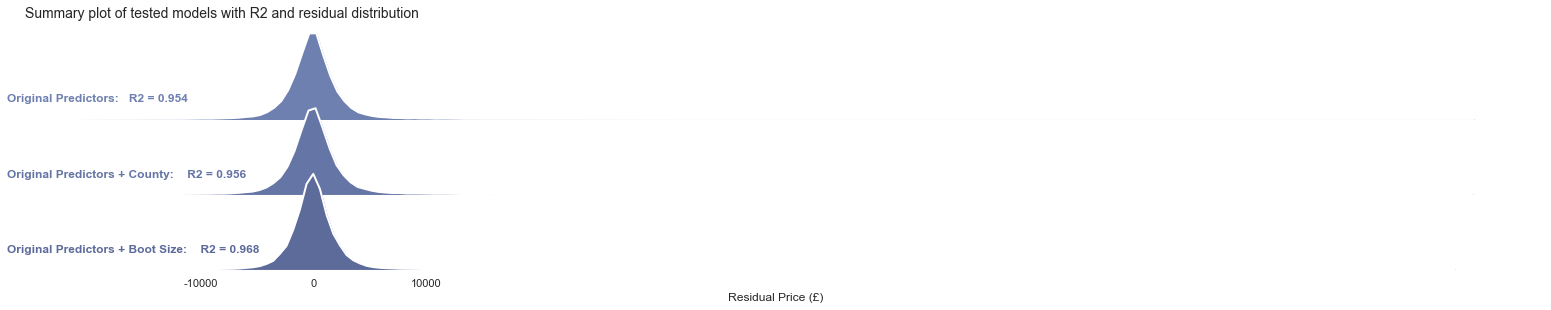

In [14]:
# Ambitious Residuals plot - needs work on X-axis

gb_resid2 = y_testgb2 - gbtest_preds2
gb_resid_county = y_testgb_county - gbtest_preds_county
gb_resid_boot = y_testgb_boot - gbtest_preds_boot

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Make the input data - really clumsy.
gb_resid_df2 = pd.DataFrame(gb_resid2)
gb_resid_df2['model']='Original Predictors:   R2 = 0.955'
gb_resid_county_df = pd.DataFrame(gb_resid_county)
gb_resid_county_df['model']='Original Predictors + County:    R2 = 0.954'
gb_resid_boot_df = pd.DataFrame(gb_resid_boot)
gb_resid_boot_df['model']='Original Predictors + Boot Size:    R2 = 0.967'

tocat=[gb_resid_df2,gb_resid_county_df,gb_resid_boot_df,]
residplotdf = pd.concat(tocat)
residplotdf.columns = ['Residual Price (£)', 'model']

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.5)
g = sns.FacetGrid(residplotdf, row="model", hue="model", aspect=15, height=1.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Residual Price (£)",
      bw_adjust=.5, clip_on=True,
      fill=True, alpha=1, linewidth=1)
g.map(sns.kdeplot, "Residual Price (£)", clip_on=False, color="w", lw=2, bw_adjust=.5)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Residual Price (£)")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)
#setting xticks

ticks = [-10000, 0, 10000]
labels = [i for i in ticks]
g.set(xticks = ticks, xticklabels = labels)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
plt.title('Summary plot of tested models with R2 and residual distribution',x=0.14, y=2.45, fontsize=14)
g.despine(bottom=True, left=True)
plt.savefig('furthermodelsummary.pdf',bbox_inches='tight')
plt.show()

There are two very simple conclusions to make:

* Adding `dealer_county` information did not improve model performance.
* Adding `cargo_volume_L` information did improve model performance, with R<sup>2</sup> scores increasing from 0.955 to 0.967. 

This work took a very long time to complete and it was a little disappointing to find that the `dealer_county` doesn't measurably impact used car price. There was better news on the `cargo_volume_L` front though. Being able to increase model performance by 1% may seem small but that may be a highly profitable 1% in some circumstances - it's a shame I wasn't being paid for this! 

This 1% increase in model R<sup>2</sup> score concludes Notebook 06_Modelling_version2. I'm now going to write all of these findings in a detailed README.md file.